# Machine Learing Development for Sales Forecasting

Another possible solution is to use machine learning algorithms to create predictive models based on sales data, to identify the market characteristics that most influence the the amount of sales. Once we identify these characteristics, they can focus their monitoring efforts on product with a higher likelihood of improving sales. 

The case of big mart sales can be treated as a regression problem. The goal is to forecast sales. The target variable in this case can be specified as a nominal variable, which are sales amount in a year

A wide range of machine learning algorithms can be used to solve the problem, we will use:

+ Linear regression techniques, such as LinearRegression, which use a linear function to predict the amount of sales.
+ Decision tree algorithms can be used to simulate more complex interactions between input factors and the target variable. RandomForestRegressor is a machine-learning model built from a collection of decision trees, each of which is trained on a different subset of training data. The program averages the predictions of all the trees to provide a final prediction.

To evaluate the performance of machine learning models, we will use various metrics, such as `mean absolute error (MAE)`, `mean squared error (MSE)`, `root mean squared error (RMSE)`, `R-Squared`, `mean absolute percentage error (MAPE)`.



In [1]:
#@title importing necesary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pingouin as pg
import pickle
#import scikitplot as skplt

from typing import List, Tuple

from pandas.api.types import CategoricalDtype
from statsmodels.stats.contingency_tables import Table2x2
from scipy.stats import randint

from sklearn.compose import make_column_selector,make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, OrdinalEncoder,  OneHotEncoder

from sklearn.experimental import enable_halving_search_cv 
from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
                                                        
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,\
                                    learning_curve, validation_curve, RandomizedSearchCV, HalvingRandomSearchCV,\
                                    KFold, StratifiedKFold
                                    
from sklearn.pipeline import Pipeline,make_pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor, ExtraTreesRegressor

import warnings
warnings.filterwarnings('ignore')

import time

We have performed some feature engineering in the data exploration phase and some feature have therefore become obsolete. We will have to drop those columns. Also we will be using different encoders for the category columns based on its characteristics.

In [2]:
# load the dataset
# load the data (cleaned)
bigmart = pd.read_csv('bigmart_cleaned.csv')

bigmart_copy = bigmart.copy() # create a copy of the data
bigmart_copy.head()

,Item_Weight,Item_Fat_Content,Item_Visibility (%),Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Type_Category,Item_MRP_Category
0,9.30,NaN,200.0,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14,Food,Very High
1,5.92,Regular,200.0,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4,Drink,Low
2,17.50,NaN,200.0,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14,Food,High
3,19.20,Regular,1200.0,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,15,Food,High
4,8.93,No Fat,600.0,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26,Non-Consumable,Low


In [3]:
# @let start with data preprocessing

# set the seed
seed = 200

# set the feature and target variable
X = bigmart_copy.drop('Item_Outlet_Sales', axis = 1)
y = bigmart_copy.Item_Outlet_Sales

# split data into train and test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle = True, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

# create a list of numerical column
num_selector = make_column_selector(dtype_exclude='object')

# create two set of of category selector, one of ordinal type and 
# other of nominal type
cat_selector_nom = make_column_selector(dtype_include='object')
cat_selector_ord= make_column_selector(dtype_include= 'category')

# sekect this column from the data
num_cols = num_selector(X)
cat_cols_ord = cat_selector_ord(X)
cat_cols_nom = cat_selector_nom(X)

# initiate the preprocessor for each selctor
num_preprocessor = RobustScaler()
cat_selector_nom_preprocessor = OneHotEncoder()
cat_selector_ord_preprocessor = OrdinalEncoder()

# set the preprocessor
preprocesor = ColumnTransformer([
    ('RobustScaler', num_preprocessor, num_cols),
    ('OneHotEncoder', cat_selector_nom_preprocessor, cat_cols_nom),
    ('OrdinalEncoder', cat_selector_ord_preprocessor, cat_cols_ord)
])

# create a machine model pipeline
pipelines = {
    'Linear Regression':make_pipeline(preprocesor, LinearRegression()),
    'Random Forest Regressor': make_pipeline(preprocesor, RandomForestRegressor()),
    'Gradient Boost Regression':make_pipeline(preprocesor, GradientBoostingRegressor()),
    'Extra Tree Regressor':make_pipeline(preprocesor, ExtraTreesRegressor())
}


Table 1 display the scoring metrics of all four of our Machine Learning models. Analyzing the data, we can see that the Random Forest Classifier and Extra tree regressor are both suffering from overfitting, which means that the models have stored the training data too well, adapting too much to the specific features of this data and thus becoming unable to generalize to the new data. This can be seen from the fact that all scoring metrics scored perfect in the training set, while scoring significantly lower in the test set. This is an important sign that the model is unable to generalize well to new data, thus making it unreliable for real-life use.
gradient boost regressor showed a small discrepancy between train and test set scores, indicating that the model may be prone to overfitting and not generalize well on new data. However, this difference is quite small, so the model may still be useful for our analysis.

Finally, the Linear Regression model scored almost identically in both data sets, making it the best candidate to pursue our analysis. This indicates that the model has learned to generalize well to the relationships between variables in the problem and could be reliable for real-life use.

In [4]:
# create a function to get model metrics
def metrics_from_pipes(pipes_dict):
    ''' 
    This function takes as input a dictionary of ML pipelines  and
    returns a table all the train and test metrics for
    each model in the dictionary
    '''
        
    # create a list for each evaluation metrics to store the metric
    # for each model
    train_mae = []
    train_mape = []
    train_rsquared = []
    train_rmse = []
    
    val_mae = []
    val_mape = []
    val_rsquared = []
    val_rmse = []
    
    # fit model and get the metrics
    for name, pipeline in pipes_dict.items():
        
        pipeline.fit(X_train, y_train)
        y_pred_val = pipeline.predict(X_val)
        y_pred_train = pipeline.predict(X_train)
        

        # get the evaluation Metrics for train
        train_mae.append(mean_absolute_error(y_train, y_pred_train))
        train_mape.append(mean_absolute_percentage_error(y_train, y_pred_train))
        train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
        train_rsquared.append(r2_score(y_train, y_pred_train))
        
        # get the evaluation metrics for validation
        val_mae.append(mean_absolute_error(y_val, y_pred_val))
        val_mape.append(mean_absolute_percentage_error(y_val, y_pred_val))
        val_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred_val)))
        val_rsquared.append(r2_score(y_val, y_pred_val))
        
    # aggregate the performance metric lists into seperate dataframes
    train_metrics = {
            'Model':list(pipes_dict.keys()),
            'MAE':train_mae,
            'MAPE':train_mape,
            'RMSE':train_rmse,
            'RSquared':train_rsquared
        }
        
    train_metrics_data = pd.DataFrame.from_dict(train_metrics)
    #columns = ['model', 'MAE', 'MAPE', 'RMSE', 'RSquared']
    val_metrics = {
            'Model':list(pipes_dict.keys()),
            'MAE':val_mae,
            'MAPE':val_mape,
            'RMSE':val_rmse,
            'RSquared':val_rsquared            
        }
        
    val_metrics_data = pd.DataFrame(val_metrics)
        
    #Merging metrics from train and test set
    train_val_metrics = train_metrics_data.merge(val_metrics_data,
                                               on = 'Model',
                                               how = 'left',
                                               suffixes = ('_train', '_val'))
        
    # sorting columns 
    train_val_metrics = train_val_metrics.reindex(columns = ['Model',
                                                               'MAE_train',
                                                                'MAPE_train',
                                                                'RMSE_train',
                                                                'RSquared_train',
                                                                'MAE_val',
                                                                'MAPE_val',
                                                                'RMSE_val',
                                                                'RSquared_val'])
        
    
    
    return train_val_metrics.set_index('Model').transpose()
    #return train_metrics
# get the metrics table
metrics_table = metrics_from_pipes(pipelines)
print('Table 1: Base Models Metrics')
#metrics_table.style.background_gradient(cmap = Blues)
metrics_table

Table 1: Base Models Metrics


Model,Linear Regression,Random Forest Regressor,Gradient Boost Regression,Extra Tree Regressor
MAE_train,829.102341,289.421353,712.963727,2.483015e-12
MAPE_train,1.030237,0.210137,0.538245,1.147776e-15
RMSE_train,1120.554271,416.427720,1012.399202,3.676770e-12
RSquared_train,0.559829,0.939210,0.640698,1.000000e+00
MAE_val,855.925441,807.208887,773.092530,8.433456e+02
MAPE_val,1.039549,0.562819,0.543980,5.868928e-01
RMSE_val,1148.654990,1166.293876,1111.878422,1.220318e+03
RSquared_val,0.587671,0.574910,0.613651,5.346170e-01


Figure 5 represents the distribution of accuracy scores (percentage of correct predictions) obtained by cross-validation, which divides the data set into several folders, using one folder as the validation set and the others as the training set. This process is repeated for each folder and finally, the results are combined, such as by calculating the mean, to obtain an estimate of the model performance. We can visually see what was expressed in table 2 confirming that Logistic regression and Gradient boost regressor has the best performance

We can see from the diagram below that on performing cross validation, Gradient boosting regressor performed better that the other 3 models. we will be performing some hyperparameter tuning on the model.

Our focus now will be on perofrming hyperparameter tuning on the Gradient boost regressor model

Figure 5: Cross-Validation performance for K-Neighbors Classifier, Logistic Regression, Random Forest Classifier.


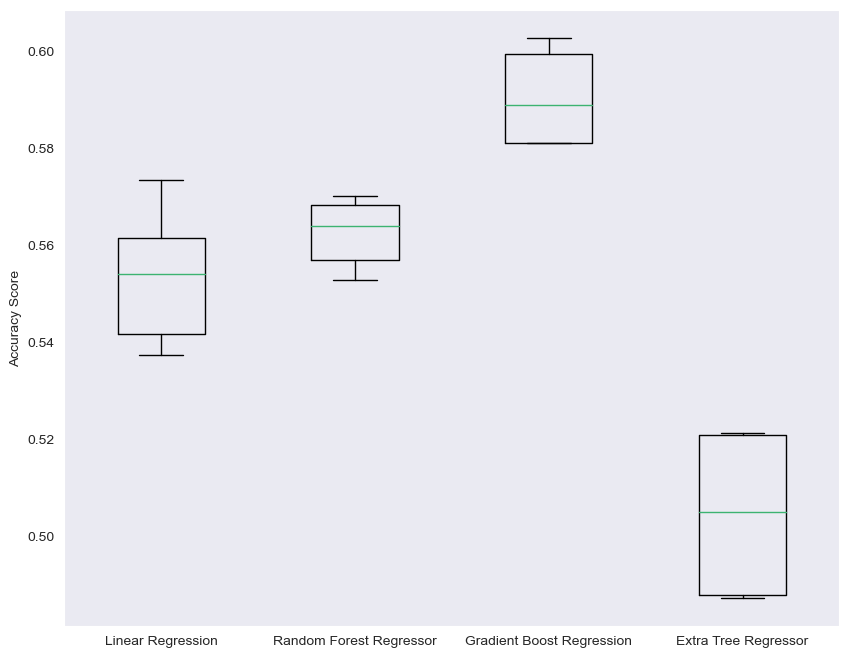

Linear Regression Test Set Accuracy: 0.5876710102285392
Random Forest Regressor Test Set Accuracy: 0.5808638074512196
Gradient Boost Regression Test Set Accuracy: 0.6142582340450572
Extra Tree Regressor Test Set Accuracy: 0.5338384337718602


In [5]:
# create a box plot to see initial model performance using R-squared
def boxplot_cv_performance(pipelines_dict):
    results = []
    
    for pipeline in pipelines_dict.values():
        # perfrom cross validation
        k_fold = KFold(n_splits=5)
        K_fold_result = cross_val_score(pipeline, X_train, y_train,
                                       cv = k_fold)
        results.append(K_fold_result)
    
    # plot the cross validation result
    sns.set_style('dark')
    fig = plt.figure(figsize=(10, 8))
    plt.boxplot(results, labels=pipelines.keys(),
               medianprops={'color':'mediumseagreen'})
    plt.ylabel('Accuracy Score')
    
    plt.show()
    
    for name, pipeline in pipelines_dict.items():
        pipeline.fit(X_train, y_train)
        validation_score = pipeline.score(X_val, y_val)
        print(f"{name} Test Set Accuracy: {validation_score}")


        
print('Figure 5: Cross-Validation performance for K-Neighbors Classifier, Logistic Regression, Random Forest Classifier.')
boxplot_cv_performance(pipelines)

### Hyperparameter Tuning

#### 1. Gradient Boost Regression

In [6]:
# set the start time
start_time = time.time()

# set the hyperparameters

param_grid = {'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
             'gradientboostingregressor__learning_rate':np.arange(0.0, 5, 0.01),
             'gradientboostingregressor__n_estimators':np.arange(50, 1000, 50),
             'gradientboostingregressor__criterion':['friedman_mse', 'squared_error'],
             'gradientboostingregressor__min_samples_split':np.arange(2, 10, 2),
             'gradientboostingregressor__min_samples_leaf':np.arange(1, 10, 1),
             'gradientboostingregressor__max_depth':np.arange(1, 10, 1)}

# initialize cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

#apply the cross vaidation
grid_grad_boost = RandomizedSearchCV(estimator=pipelines['Gradient Boost Regression'],
                            param_distributions = param_grid,
                            cv = cv,
                            n_jobs=-1,
                            random_state = seed)

grid_grad_boost.fit(X_train, y_train) # fit the parameters

end_time = time.time()
execution_time = (end_time - start_time)/60

print(f'The best estimator is: {grid_grad_boost.best_estimator_}\n'
      f'The best params are: {grid_grad_boost.best_params_}\n'
      f'The best score is: {grid_grad_boost.best_score_}\n'
      f'Execution time: {execution_time:.3f} minutes')

The best estimator is: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('RobustScaler',
                                                  RobustScaler(),
                                                  ['Item_Weight',
                                                   'Item_Visibility (%)',
                                                   'Item_MRP', 'Outlet_Age']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  ['Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Identifier',
                                                   'Outlet_Size',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type',
                                        

#### 2. Linear Regression

WE can see that linear regression has a best score of 0.55 which is slightly higher than that of gradient boost regressor

In [14]:
# set the start time
start_time_lr = time.time()

# set the hyperparameters

param_grid_lr = {'linearregression__fit_intercept':[True, False],
             'linearregression__copy_X':[True, False],
             'linearregression__n_jobs':np.arange(1, 15, 1),
             'linearregression__positive':[True, False],
             }

# initialize cross validation
cv_lr = KFold(n_splits=5, shuffle=True, random_state=seed)

#apply the cross vaidation
grid_lr = RandomizedSearchCV(estimator=pipelines['Linear Regression'],
                            param_distributions = param_grid_lr,
                            cv = cv_lr,
                            n_jobs=-1,
                            random_state = seed)

grid_lr.fit(X_train, y_train) # fit the parameters

end_time_lr = time.time()
execution_time_lr = (end_time_lr - start_time_lr)/60

print(f'The best estimator is: {grid_lr.best_estimator_}\n'
      f'The best params are: {grid_lr.best_params_}\n'
      f'The best score is: {grid_lr.best_score_}\n'
      f'Execution time: {execution_time_lr:.3f} minutes')

The best estimator is: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('RobustScaler',
                                                  RobustScaler(),
                                                  ['Item_Weight',
                                                   'Item_Visibility (%)',
                                                   'Item_MRP', 'Outlet_Age']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  ['Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Identifier',
                                                   'Outlet_Size',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type',
                                        

### Model Development using the tuned hyperparameters

The following observation can be deduced from the result:
+ Gradient Booost regressor has better mean absolute error and mean absolute percentage error that linear regression model
+ linear regression model has better RMSE value and R-squared value compared to Gradient boost regressor

But based upon their RMSE and R-squared value (which are the mos used metrics for evaluating regression models), we can say that linear regression model performed better.

In [18]:
# create a function to get model metrics
def metrics_test_tuned(model):
    ''' 
    This function takes as input a dictionary of ML pipelines  and
    returns a table all the train and test metrics for
    each model in the dictionary
    '''
        
    # create a list for each evaluation metrics to store the metric
    # for each model
    test_mae = []
    test_mape = []
    test_rsquared = []
    test_rmse = []
    
    #initilize the model 
    mod = model.best_estimator_
    y_pred_test = mod.predict(X_test)
        

        # get the evaluation Metrics for train
    test_mae.append(mean_absolute_error(y_test, y_pred_test))
    test_mape.append(mean_absolute_percentage_error(y_test, y_pred_test))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    test_rsquared.append(r2_score(y_test, y_pred_test))
        
        
    # aggregate the performance metric lists into seperate dataframes
    test_metrics = {
            'Model':[model.best_estimator_.steps[-1][1].__class__.__name__],
            'MAE':test_mae,
            'MAPE':test_mape,
            'RMSE':test_rmse,
            'RSquared':test_rsquared
        }
        
    test_metrics_data = pd.DataFrame.from_dict(test_metrics)

                
    return test_metrics_data.transpose().reset_index().rename(columns = {'index':'metrics', 0:'values'})
    #return train_metrics
# get the metrics table for Gradient Boost Regression
metrics_table_gd = metrics_test_tuned(grid_grad_boost)
print('Table 1: Best Estimator metrics table for Gradient Boost Regression')
#metrics_table.style.background_gradient(cmap = Blues)
metrics_table_gd

Table 1: Best Estimator metrics table for Gradient Boost Regression


,metrics,values
0,Model,GradientBoostingRegressor
1,MAE,830.661343
2,MAPE,0.611924
3,RMSE,1188.768009
4,RSquared,0.511144


In [20]:
# get the metrics table
metrics_table_lr = metrics_test_tuned(grid_lr)
print('Table 1: Best Estimator metrics table for Linear Regression')
#metrics_table.style.background_gradient(cmap = Blues)
metrics_table_lr

Table 1: Best Estimator metrics table for Linear Regression


,metrics,values
0,Model,LinearRegression
1,MAE,847.196339
2,MAPE,1.007345
3,RMSE,1143.342587
4,RSquared,0.547791


### Feature Importance

Evaluating feature performances is important because it can help identify which features are most important for prediction and which can be eliminated or modified to improve model performance. In addition, understanding feature performances can help to better understand the nature of the regrression problem and identify the variables that are most significant for prediction.

From the plots below, we can conclude that the feature that affects our model the most as computed by the two models are:
+ `Item_Visibility`
+ `Item_Type`


Figure 9: RandomizedSearchCV best estimator (Linear Regression) coefficient importances.


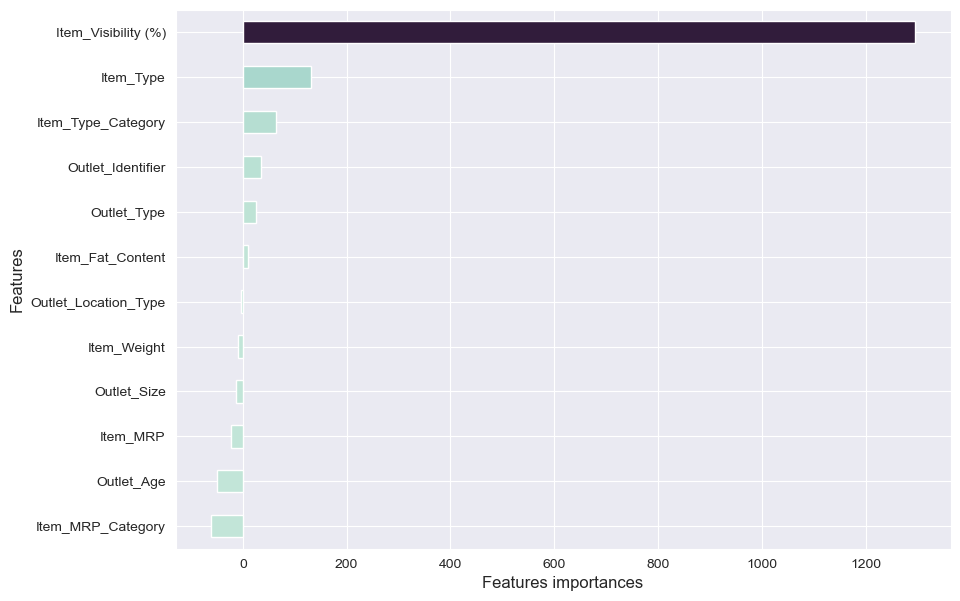

In [37]:
print('Figure 9: RandomizedSearchCV best estimator (Linear Regression) coefficient importances.')

# get the coefficients
coef_lr = grid_lr.best_estimator_.named_steps.linearregression.coef_

# get the model importance as a pandas series
importances_model_lr = pd.Series(coef_lr[:len(X.columns)],
                                index  = X.columns[:len(coef_lr[:len(X.columns)])]).sort_values()


#Plot  linearRegression coefficients
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10,7))
palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

importances_model_lr.plot(kind = 'barh', color = palette(importances_model_lr/float(importances_model_lr.max())))
plt.ylabel('Features', fontsize=12)
plt.xlabel('Features importances', fontsize=12)

plt.show()


Figure 9: RandomizedSearchCV best estimator (Gradient Boost Regression) coefficient importances.


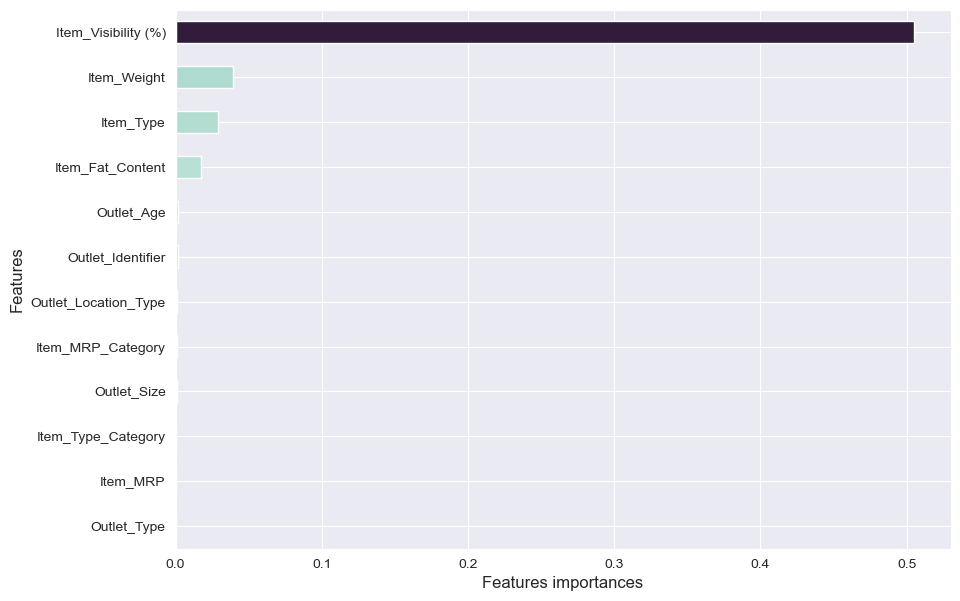

In [44]:
print('Figure 9: RandomizedSearchCV best estimator (Gradient Boost Regression) coefficient importances.')

# get the coefficients
coef_gboost = grid_grad_boost.best_estimator_.named_steps.gradientboostingregressor.feature_importances_

# get the model importance as a pandas series
importances_model_gboost = pd.Series(coef_gboost[:len(X.columns)],
                                index  = X.columns[:len(coef_gboost[:len(X.columns)])]).sort_values()


#Plot  linearRegression coefficients
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10,7))
palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

importances_model_gboost.plot(kind = 'barh', color = palette(importances_model_gboost/float(importances_model_gboost.max())))
plt.ylabel('Features', fontsize=12)
plt.xlabel('Features importances', fontsize=12)

plt.show()